This script is a pre-processing script to be used on EEG data in order to do
1. re-formatting of data from EGI to MNE 
!!! marker extraction not included but needed at this point (see example scripts)
2. filtering
3. data visualization
4. cleaning with ICA if needed
5. epoching & visual artefact rejection
6. interpolation of bad channels
7. baseline correction and average referencing 
8. averages by condition
9. various plots for clean data visualisation

written by Ruxandra Tivadar, in joint effort with Sigurd Lerkerod Alnes and Pinar Göktepe


P.S. Good little helpers are included:

-Check this link for an explanation of the computations behind data pre-processing steps and a suggestion of
the order you should apply these in
https://erpinfo.org/order-of-steps

-Check this link for an interesting discussion regarding filters
https://sapienlabs.org/pitfalls-of-filtering-the-eeg-signal/

-Check this link for example of ICA artefacts
https://labeling.ucsd.edu/tutorial/labels

## 1. REFORMATTING OF DATA

In [2]:
#import needed libraries and packages, and load data, declare path (adapt according to where you store files)
#script assumes that data are ordered in a file (e.g. mfftofif) 
#in which each participant then has their own folder with data 
#(e.g. '/Users/tivadarr/WorkFiles/Bern/Experiment_1/EEG_data/mfftofif/P11/P11S0.mff')


import mne
import os
import numpy as np

# change to your own naming of subject (sub_s), session (sess_s), and desired new sampling rate (new_srate)
sub_s         = 'P11'
ses_s         = 'S0'
new_srate      = 500

# change path to your own file storage, also change stim_ch_names if you use others, or only one of them
base_path       = '/Users/tivadarr/WorkFiles/Bern/Experiment_1/EEG_data/mfftofif/'
stim_ch_names   = [ 'audio', 'diode' ]
drop_chans      = [ 'E257', 'STI 014', 'net' ] #these channels should always be dropped from 256 EGI cap


This function takes in following variables: 
subject (sub_s), 
session (sess_s), 
folder path with single subject data (base_path), 
new sampling frequency - if resampling is desired (new_sfreq), 
filtering (notch: notch,low pass filter: lpass, high pass filter:hpass), 
stimulus channel names (stim_ch_names), 
dropped channel names (drop_chans), 
and whether to overwrite an existing file or not (as a default, overwrite is deactivated).

The function first declares the file paths for the used and for the produced files, then reads in the raw EEG data and resamples it if a new sampling frequency was declared. 
The function then renames the channels, as EGI channels are called 'eeg1', 'eeg2',....,'eegn', and the existing channel montage of EGI caps in MNE contains channels that are called 'e1','e2',...'en' (n=number of channels). In order to be able to use the existing montage, the channels are re-named.
Third, the channel produces a raw MNE .fif file containing just the stimulus data that were recorded using the Physiobox. If this is not the case for your data, you can comment out that section. This is done for later trigger 'extraction'.
Fourth, the function filters the data, sets the MNE montage to the data (so MNE can recognize the 256 EGI cap and thus the electrode coordinates)
As an output, you get the filtered and down-sampled EEG data as a .fif file, and the trigger data as a separate file.

In [2]:
def mff_to_fif(sub_s, ses_s, base_path, new_sfreq,
               notch, lpass , hpass ,
               stim_ch_names = [], drop_chans = [], overwrite = False):
  
  
  base_path     = base_path + sub_s + '/'
  raw_path      = base_path + sub_s  + ses_s + '.mff'
  raw_out_path  = base_path + sub_s + ses_s + '-raw.fif'
  stim_out_path = base_path  + sub_s + ses_s + '_stim-raw.fif'
  
  if not overwrite:
   if os.path.exists(raw_out_path):
    raise OSError('Raw fif file already exists. No overwrite.')
   elif os.path.exists(stim_out_path):
    raise OSError('Raw stim fif file already exists. No overwrite.')

  # Read in raw file
  raw           = mne.io.read_raw_egi(raw_path, preload=True)

  # Resample to new_sfreq
  if not new_sfreq == None:
    raw         = raw.resample( new_sfreq, npad = 'auto' )

  # Change channel names to the correspond to those used by the montage
  channel_mapping = {}
  for ch_i, ch_e in enumerate(raw.info['ch_names']):
    ch_name_split = ch_e.split()
    if 'EEG ' in ch_e and ch_name_split[1].isdigit():
      channel_mapping[ch_e] = 'E' + ch_name_split[1]
  mne.rename_channels(info = raw.info, mapping = channel_mapping)

  # Save stimulus channels also in separate raw file
  if len(stim_ch_names):
    s_freq          = raw.info['sfreq']
    stim_ch_types   = ['stim'] * len(stim_ch_names)
    stim_data       = np.array( [ raw._data[ raw.info['ch_names'].index(ch_name) ] for ch_name in stim_ch_names ] )
    stim_info       = mne.create_info( ch_names = stim_ch_names, sfreq = s_freq, ch_types = stim_ch_types )
    stim_raw        = mne.io.RawArray(stim_data, stim_info)
    stim_raw.save( stim_out_path, overwrite = overwrite )
    del stim_raw

  # Drop channels
  if len(drop_chans):
    raw.drop_channels( [ch for ch in drop_chans if ch in raw.info['ch_names']] )
    
  # Notch filter the raw signal
  notch_range = np.arange(notch, raw.info['sfreq'] / 2, notch)
  raw.notch_filter(notch_range, filter_length = 'auto', phase = 'zero')

  # Bandpass filter the signal
  raw.filter(l_freq = hpass, h_freq = lpass)

  # Set montage
  raw             = raw.set_montage( mne.channels.make_standard_montage('EGI_256') )
  
  # Save raw
  raw.save(raw_out_path, overwrite = overwrite )
    
  del raw

In [3]:
# applied the function to the data, change filters here (second row)
mff_to_fif(sub_s, ses_s, base_path, new_sfreq=new_srate,
               notch = 50, lpass=40, hpass = 1,
               stim_ch_names = stim_ch_names, drop_chans = drop_chans, overwrite = True)

Reading EGI MFF Header from /Users/tivadarr/WorkFiles/Bern/Experiment_1/EEG_data/mfftofif/P11/P11S0.mff...
    Reading events ...
    Assembling measurement info ...
Reading 0 ... 1883485  =      0.000 ...  1883.485 secs...
Creating RawArray with float64 data, n_channels=2, n_times=941743
    Range : 0 ... 941742 =      0.000 ...  1883.484 secs
Ready.
Writing /Users/tivadarr/WorkFiles/Bern/Experiment_1/EEG_data/mfftofif/P11/P11S0_stim-raw.fif
Closing /Users/tivadarr/WorkFiles/Bern/Experiment_1/EEG_data/mfftofif/P11/P11S0_stim-raw.fif [done]
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1

## 2. MARKER EXTRACTION
If markers are not contained in the recording already (as a channel), marker extraction is needed at this point, as the following steps need .fif eeg files that contain triggers.

# 3. PREPROCESSING
## 3.1. Visualisation

In [1]:
# first, import needed packages

import mne
import os
import numpy as np
import matplotlib.pyplot as plt
from mne.io import read_raw_fif, concatenate_raws
import copy
from scipy import signal
import mne.viz


# second, declare subject and session names, as well as the folder path with the EEG data 
# (note the change between this path and the path above, we are now using another folder that contains the data 
# from each subject in a separate folder 
# (e.g.'/Users/tivadarr/WorkFiles/Bern/Experiment_1/EEG_data/tutorial/P11/P11S0.fif')

sub_s           = 'P11'
ses_s0          = 'S0'
ses_s1          = 'S1'
new_srate       = 500
path       = '/Users/tivadarr/WorkFiles/Bern/Experiment_1/EEG_data/tutorial/'
stim_ch_names   = [ 'audio', 'diode' ]
drop_chans      = [ 'E257', 'STI 014', 'net' ]

base_path       = path + sub_s + '/' 

raw00_path      = base_path + sub_s + ses_s0 + '_trig.fif'


# check that the path is correctly written
print(raw00_path)

/Users/tivadarr/WorkFiles/Bern/Experiment_1/EEG_data/tutorial/P11/P11S0_trig.fif


Opening raw data file /Users/tivadarr/WorkFiles/Bern/Experiment_1/EEG_data/tutorial/P11/P11S0_trig.fif...
    Range : 0 ... 941742 =      0.000 ...  1883.484 secs
Ready.
Reading 0 ... 941742  =      0.000 ...  1883.484 secs...


<ipython-input-2-213860b30873>:6: RuntimeWarning: This filename (/Users/tivadarr/WorkFiles/Bern/Experiment_1/EEG_data/tutorial/P11/P11S0_trig.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw00           = read_raw_fif(raw00_path, preload=True)


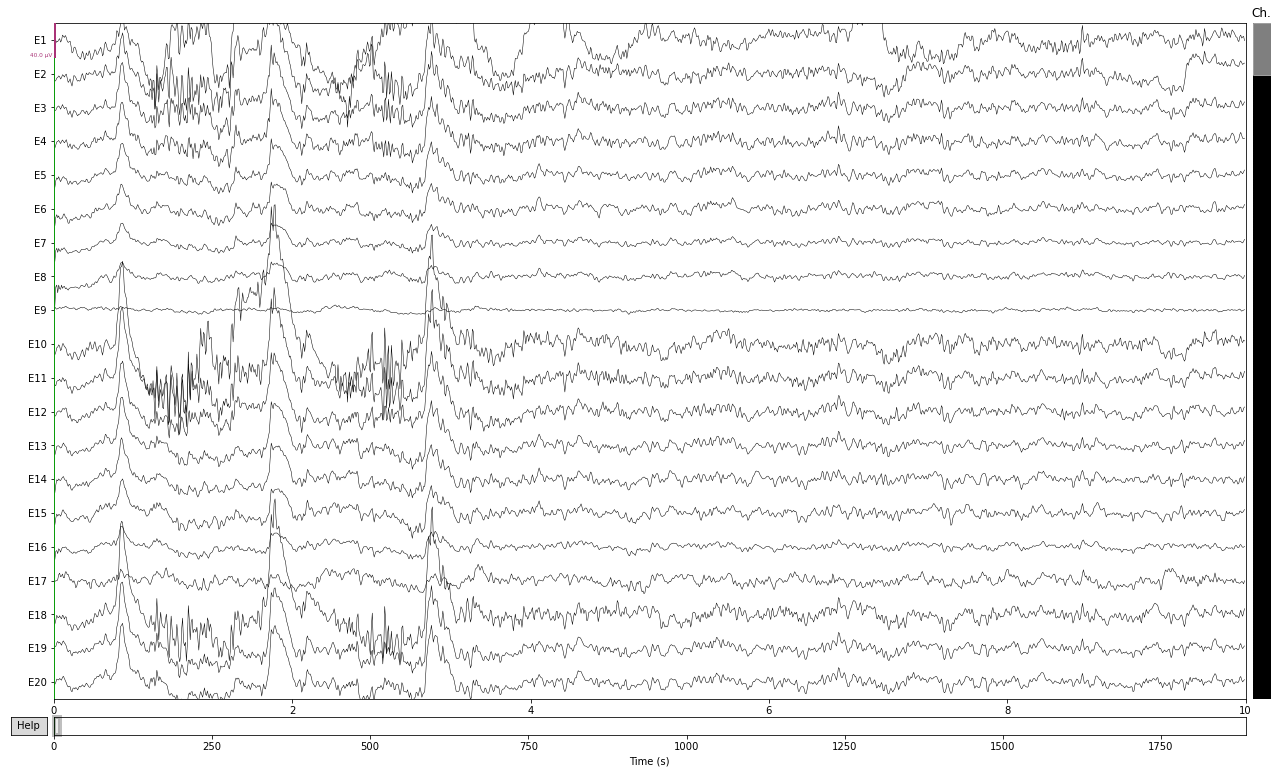

In [2]:
# Read in raw file, and plot the file to check where to crop the signal around the first and last triggers,
# in order to exclude some artifacts, otherwise the artefact correction with ICA will be problematic
# ALSO; MARK BAD CHANNELS AT THIS STAGE BY CLICKING ON THEM (also for ICA)

# read the data
raw00           = read_raw_fif(raw00_path, preload=True)

# plot to see where to crop beginning and ends, if applicable
#%matplotlib tk
mne.viz.plot_raw(raw00, remove_dc=True)
#raw00.info['bads']=['E255', 'E73', 'E209', 'E242', 'E235', 'E217', 'E92', 'E102', 'E91', 'E170', 'E216', 'E208', 'E187', 'E199', 'E111', 'E120', 'E82', 'E112', 'E133', 'E101', 'E10', 'E18', 'E218', 'E237', 'E55', 'E54', 'E121']

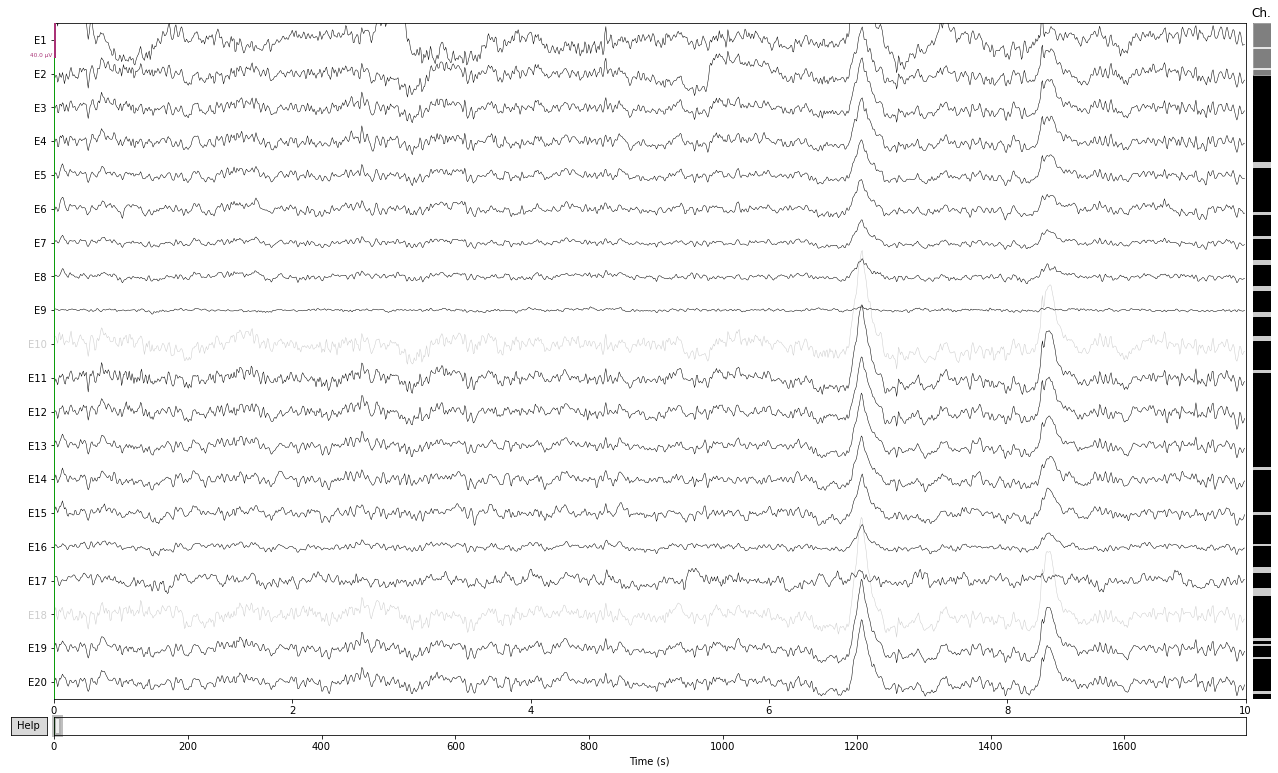

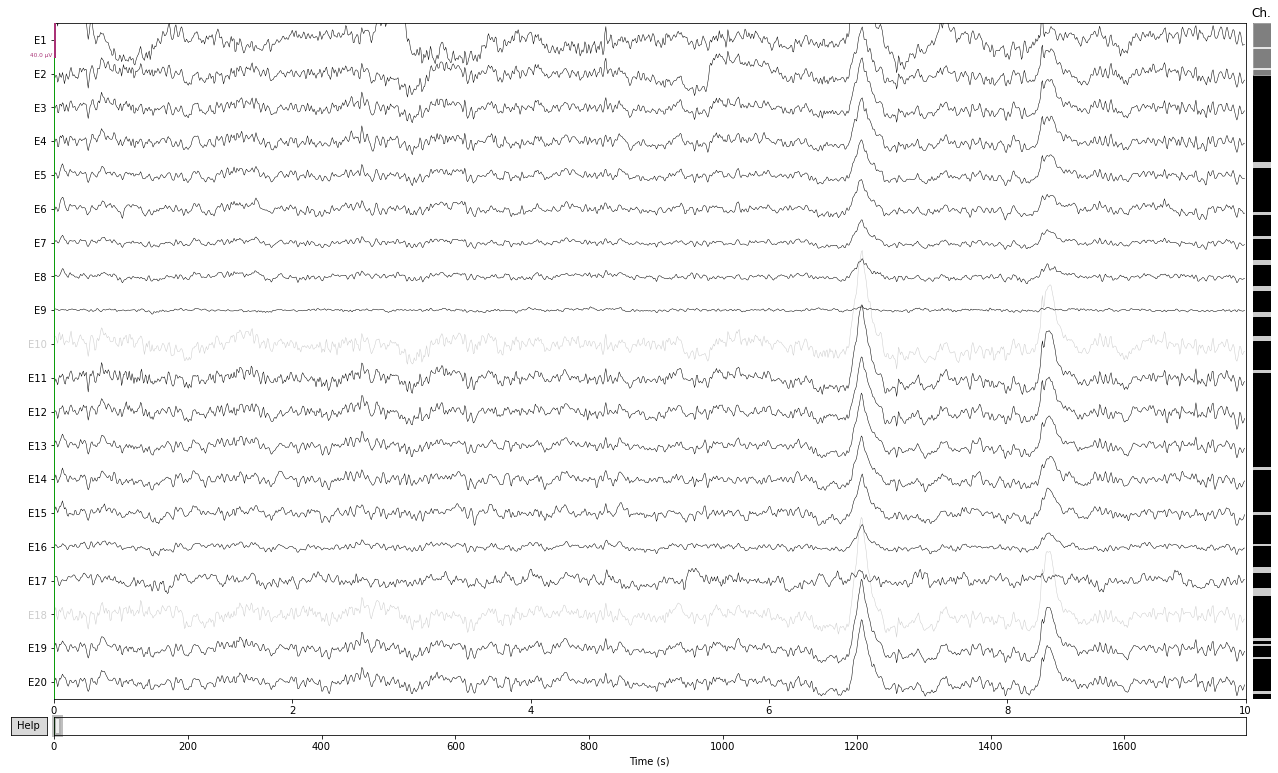

In [3]:
# crop the data
raw00= raw00.crop(tmin=4,tmax=1785) 

# replot to mark bad channels
mne.viz.plot_raw(raw00, remove_dc=True)

## 3.2. ICA cleaning (if needed)

In [4]:
##### ICA ######

#import packages
from mne.preprocessing import (ICA, find_eog_events, find_ecg_events,create_eog_epochs, create_ecg_epochs,
                               corrmap)

#apply ICA so that resolved components explain 95% of variance in the data
ica = ICA(n_components=0.95)
ica.fit(raw00)

Fitting ICA to data using 229 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by explained variance: 50 components
Fitting ICA took 90.9s.


<ICA  |  raw data decomposition, fit (fastica): 890501 samples, 50 components, channels used: "eeg">

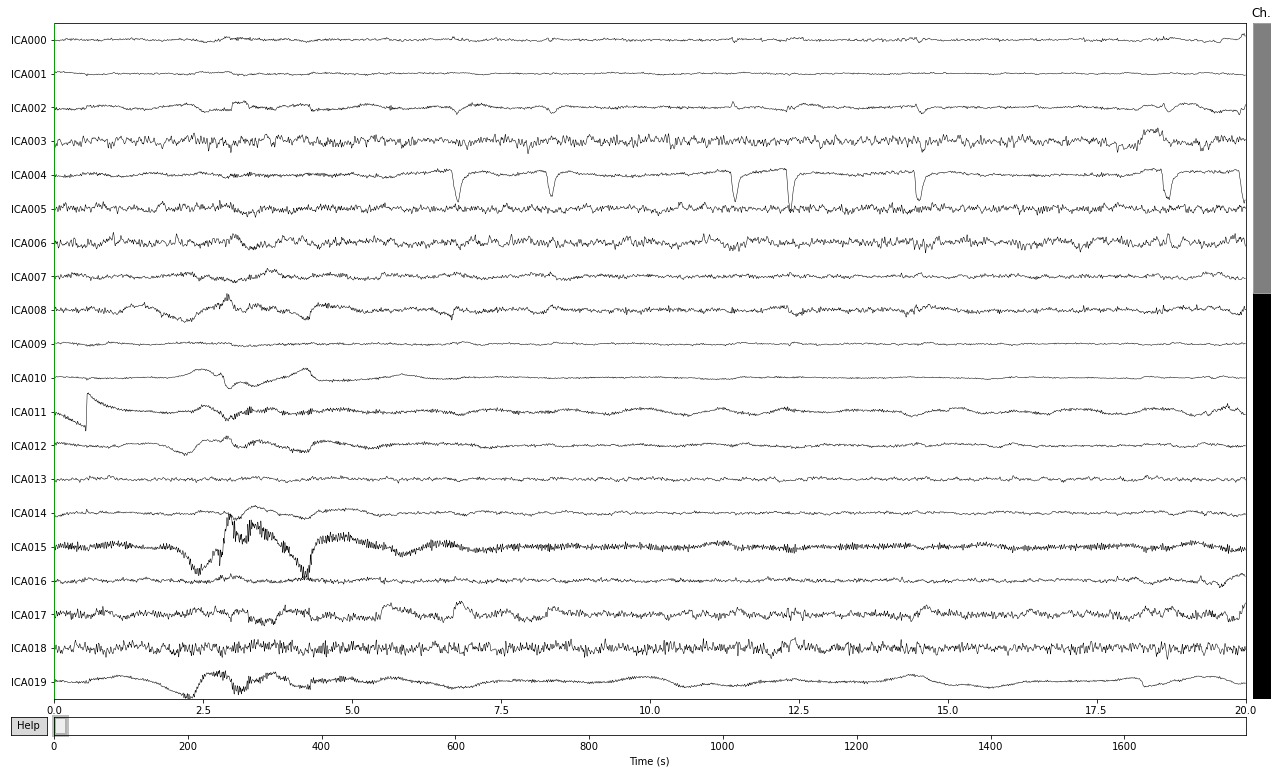

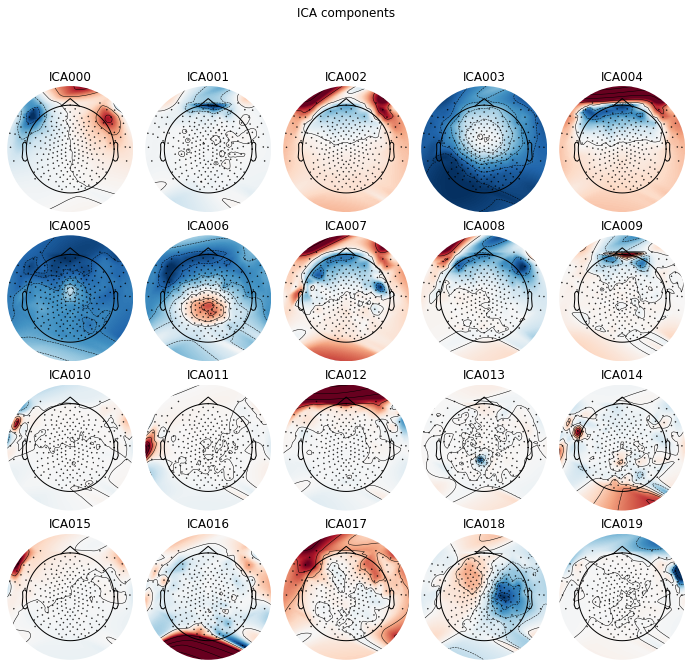

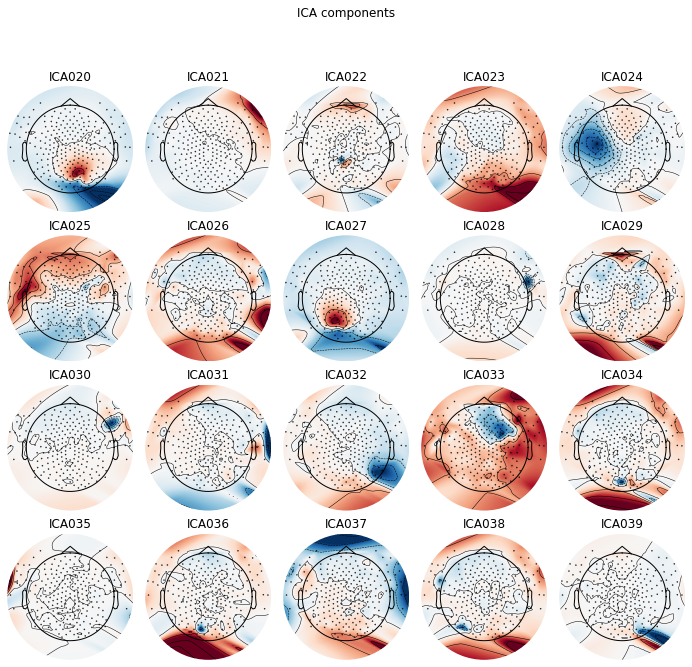

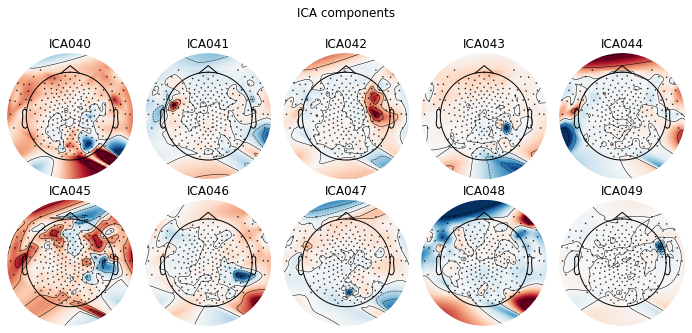

[<Figure size 702x678.24 with 20 Axes>,
 <Figure size 702x678.24 with 20 Axes>,
 <Figure size 702x339.12 with 10 Axes>]

In [5]:
# To plot ICA components and check them for exclusion

raw00.load_data()
ica.plot_sources(raw00)
ica.plot_components(inst=raw00)

Transforming to ICA space (50 components)
Zeroing out 6 ICA components


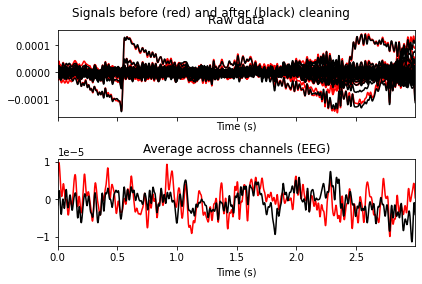

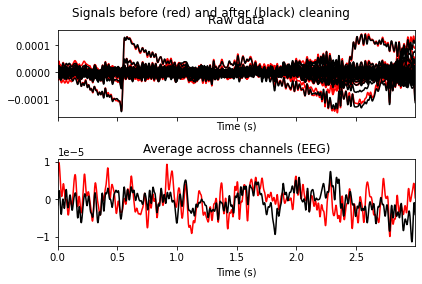

In [6]:
#To visualize excluded components (does not ACTUALLY exclude them)

ica.plot_overlay(raw00, exclude=[(0,3,4,12,23,49)])

In [7]:
#To ACTUALLY exclude ICA components

#declare the components you want to exclude
ica.exclude = [0,3,4,12,23,49]

#make a copy to visualize the artefact exclusion on raw data in a next step
raw1 =copy.deepcopy(raw00)
ica.apply(raw1)

Transforming to ICA space (50 components)
Zeroing out 6 ICA components


<Raw | P11S0_trig.fif, 257 x 890501 (1781.0 s), ~1.71 GB, data loaded>

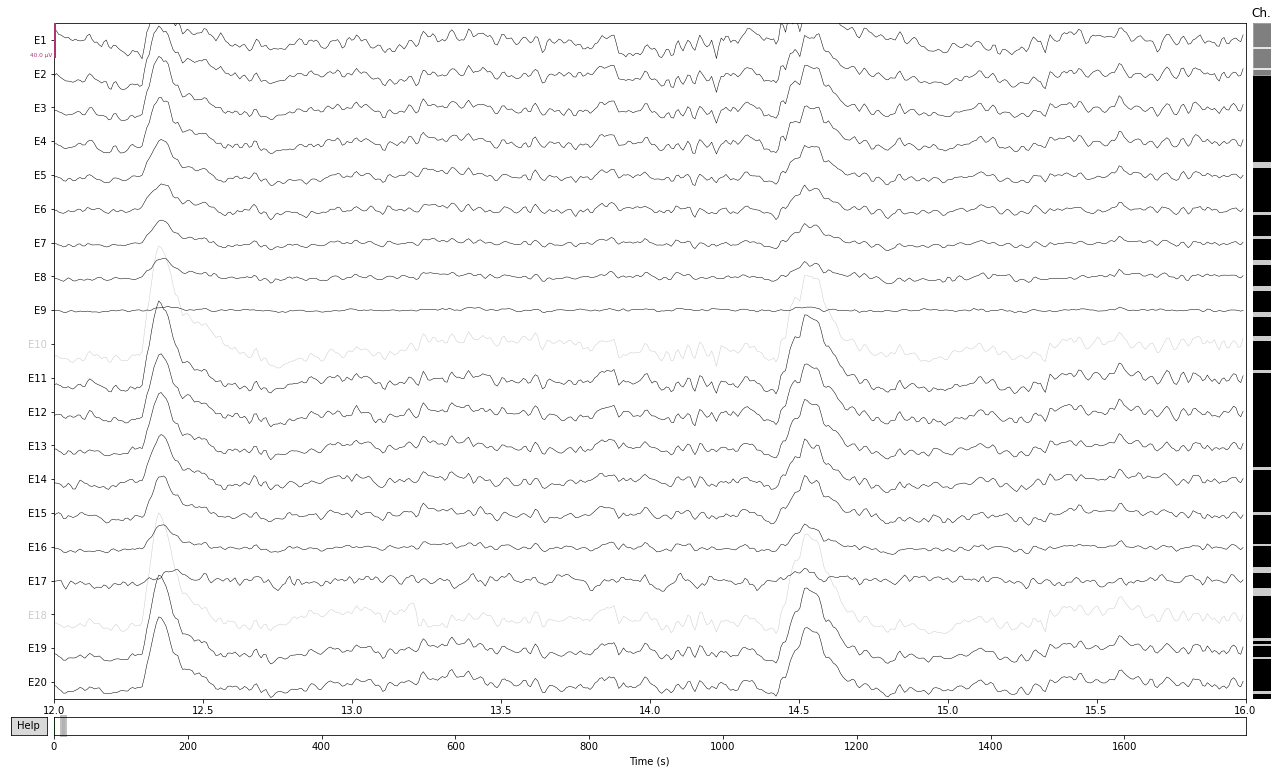

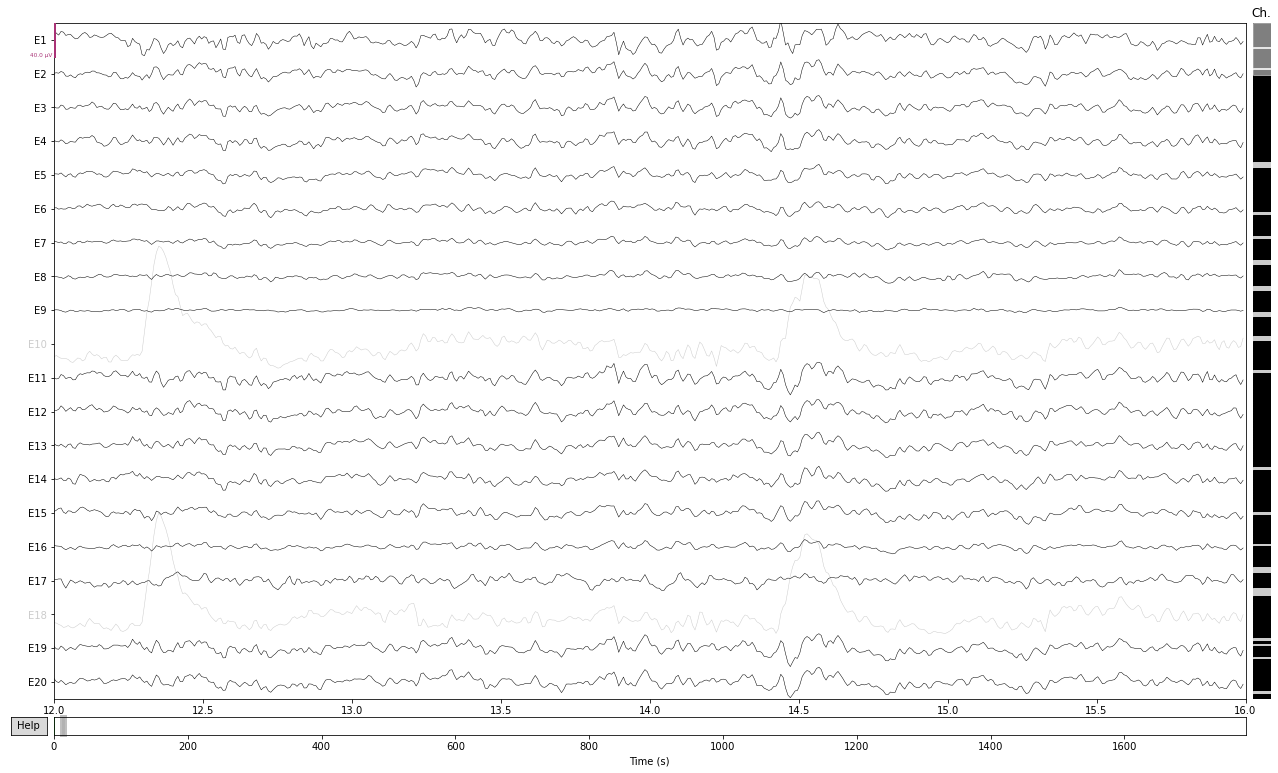

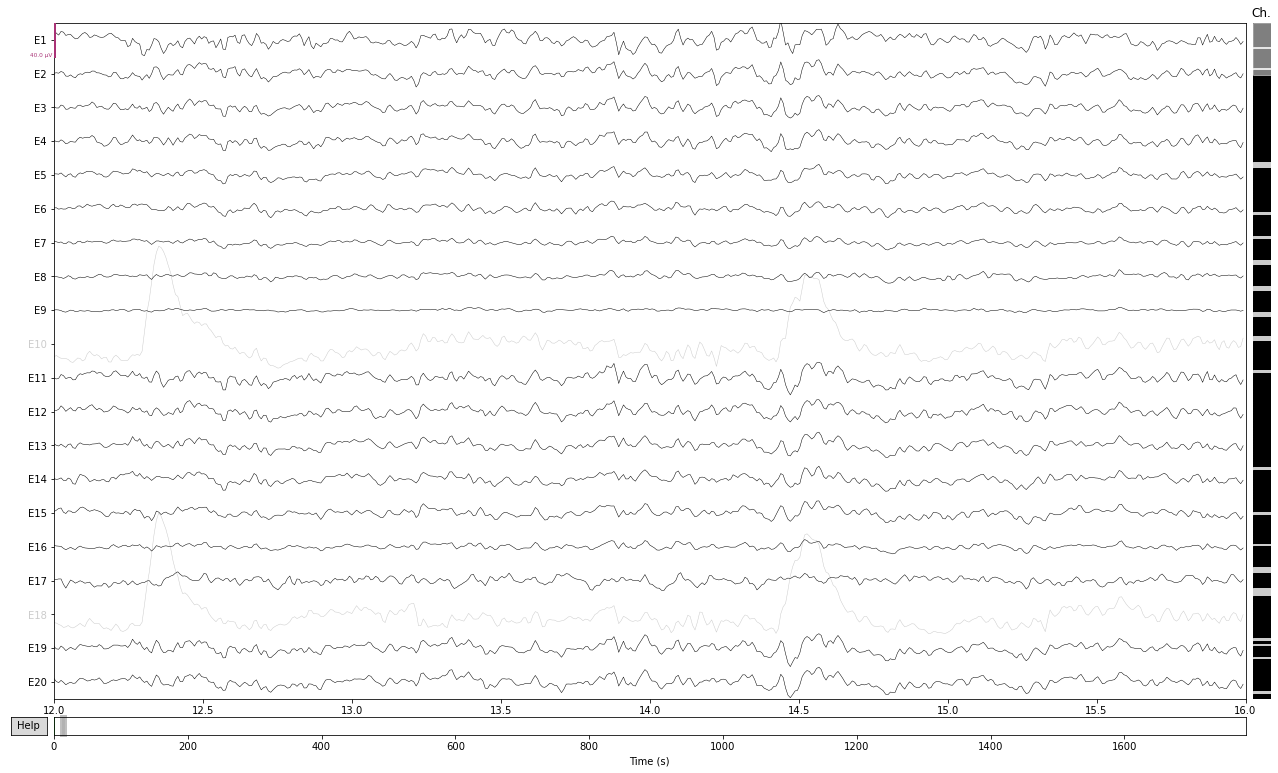

In [8]:
# show some channels to clearly illustrate the artifact removal

chs = raw1.ch_names[:257]
chan_idxs = [raw1.ch_names.index(ch) for ch in chs]
raw00.plot(order=chan_idxs, start=12, duration=4)
raw1.plot(order=chan_idxs, start=12, duration=4)

In [9]:
# Save raw file after ICA
print( base_path +sub_s + "-ICA_raw.fif")
#np.save(fepochs[0:len(fepochs) - 8] + "_cleaned-epo.fif",epochs)#overwrite=True
raw1.save(base_path + sub_s + "-ICA_raw.fif")#, overwrite=True)

# Delete original file to free up memory

del(raw00)

/Users/tivadarr/WorkFiles/Bern/Experiment_1/EEG_data/tutorial/P11/P11-ICA_raw.fif
Writing /Users/tivadarr/WorkFiles/Bern/Experiment_1/EEG_data/tutorial/P11/P11-ICA_raw.fif
Closing /Users/tivadarr/WorkFiles/Bern/Experiment_1/EEG_data/tutorial/P11/P11-ICA_raw.fif [done]


## 3.3. Epoching

In [10]:
###### To make epochs ######

# find the triggers from the stimulus channes (here:audio triggers, otherwise replace with channel name)
events = mne.find_events(raw1, stim_channel='audio')

# Show the number of events (number of rows)
print('Number of events:', len(events))

# Show all unique event codes (3rd column): these are the triggers you coded, and they are specific to your data
print('Unique event codes:', np.unique(events[:, 2]))


479 events found
Event IDs: [  1  30  31  70  71 101]
Number of events: 479
Unique event codes: [  1  30  31  70  71 101]


479 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 479 events and 901 original time points ...
0 bad epochs dropped


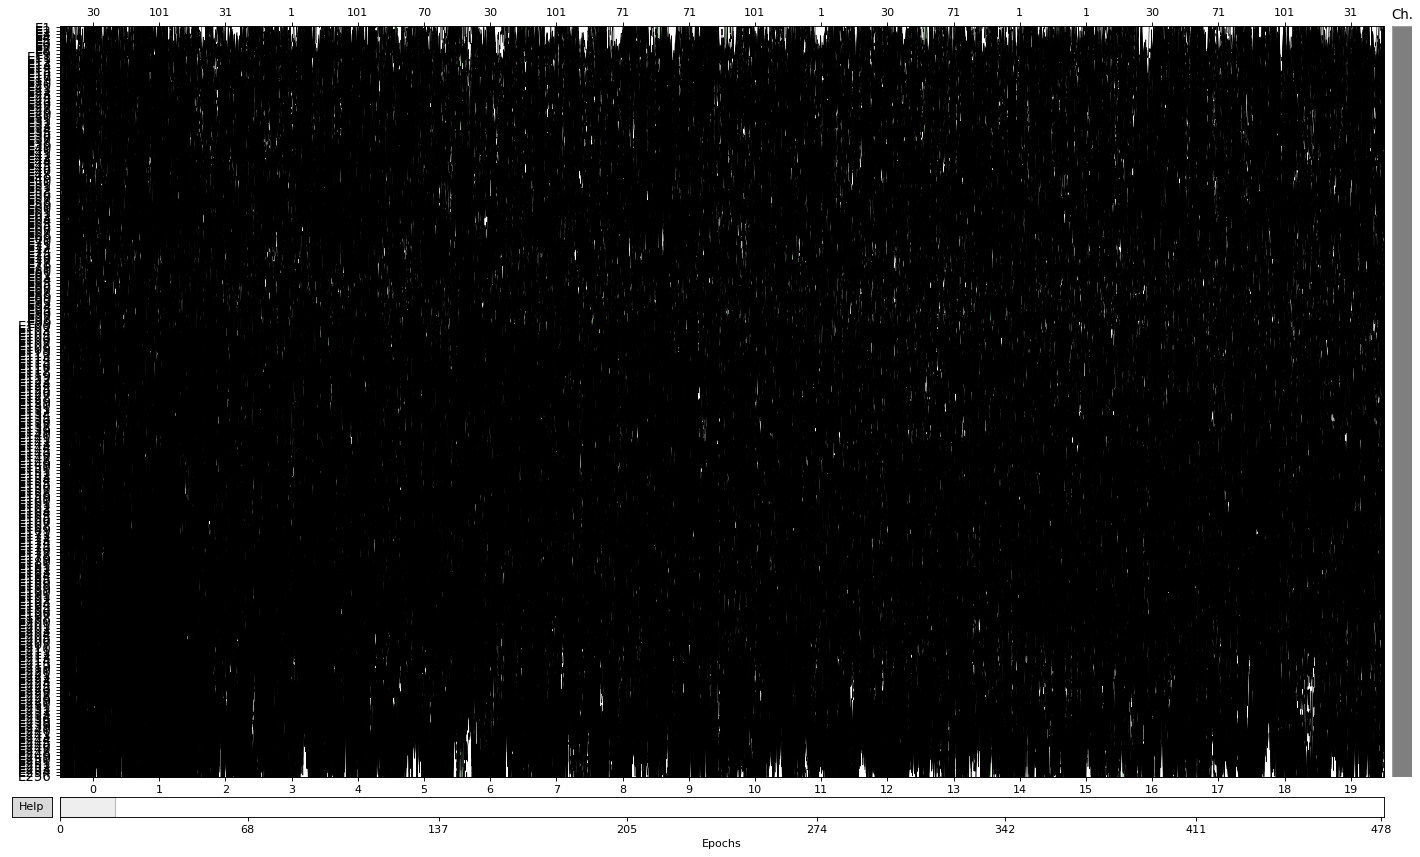

Dropped 204 epochs: 0, 1, 6, 28, 31, 39, 40, 42, 80, 98, 101, 108, 135, 154, 159, 170, 178, 181, 182, 185, 186, 187, 189, 190, 191, 193, 195, 198, 199, 202, 203, 204, 205, 209, 216, 219, 220, 221, 223, 224, 225, 226, 237, 239, 241, 243, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 277, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294, 296, 297, 299, 300, 301, 303, 307, 308, 311, 315, 316, 317, 318, 319, 320, 321, 322, 323, 326, 327, 328, 329, 330, 331, 332, 337, 340, 342, 345, 348, 349, 350, 351, 352, 353, 355, 357, 359, 366, 367, 368, 369, 370, 371, 372, 373, 374, 377, 378, 379, 380, 382, 383, 384, 385, 386, 387, 389, 391, 393, 394, 395, 398, 399, 400, 405, 407, 408, 411, 413, 414, 418, 420, 424, 425, 428, 429, 430, 431, 432, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473

In [11]:
#######  Epoching & Cleaning  #######

#define period of interest around your triggers, i.e. the time of your epoch, using tmin and tmax
tmin, tmax = -0.1, 1.7 

# map event IDs to tasks
# create a dictionary with names for your triggers (makes life easier for you, if you forget your triggers)
event_ids = dict(zero=1, silence30=30, target30=31, silence70=70, target70=71,hundred=101)  

# extract epochs from data
epochs=mne.Epochs(raw1, events, event_ids, tmin,tmax,baseline=None,preload=True)
n_ch = len(raw1.info['ch_names'])

# Take a note of your epochs before cleaning
before_cleaning=epochs.selection

#plot epochs in a visual GUI and mark the bad ones using the mouse (you can also mark extra bad channels here)
# PRESS CMD+S (or linux/windows shortcut for save) before exiting the GUI
#%matplotlib tk
epochs.plot(block=True, n_channels = n_ch, scalings='auto')
epochs.drop([0,1,6,28,31, 39, 40, 42, 80, 98, 101, 108, 135, 154, 159, 170, 178, 181, 182, 185, 186, 187, 189, 190, 191, 
193, 195, 198, 199, 202, 203, 204, 205, 209, 216, 219, 220, 221, 223, 224, 225, 226, 237, 239, 241, 243, 248, 
249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 277, 
279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294, 296, 297, 299, 300, 301, 303, 307, 
308, 311, 315, 316, 317, 318, 319, 320, 321, 322, 323, 326, 327, 328, 329, 330, 331, 332, 337, 340, 342, 345, 
348, 349, 350, 351, 352, 353, 355, 357, 359, 366, 367, 368, 369, 370, 371, 372, 373, 374, 377, 378, 379, 380, 
382, 383, 384, 385, 386, 387, 389, 391, 393, 394, 395, 398, 399, 400, 405, 407, 408, 411, 413, 414, 418, 420, 
424, 425, 428, 429, 430, 431, 432, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446, 447, 448, 449, 450, 
451, 452, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 
476, 477, 478])
# Take a note of your epochs after cleaning
after_cleaning=epochs.selection 

# compare epochs before and after cleaning
print(len(after_cleaning))
print(len(before_cleaning))

In [15]:
# save IDs of rejected epochs
after_cleaning=epochs.selection 

rejectedEpochs=[before_cleaning[i] for i in range(len(before_cleaning)) if before_cleaning[i] not in after_cleaning]

rejectedEpochs_ids=[np.where(before_cleaning==rejectedEpochs[i])[0][0] for i in range(len(rejectedEpochs))]
print(len(rejectedEpochs_ids))
print(rejectedEpochs_ids)
rejectedEpochs_ids=np.asarray(rejectedEpochs_ids)

filename_ep=base_path+sub_s+'rejectedEpochs'
np.savetxt(filename_ep,rejectedEpochs_ids,delimiter=',')

#Save IDs of bad channels
filename_ch=base_path+sub_s+'badChannels'
badchan=epochs.info['bads']
print(badchan)
badchan=np.asarray(badchan)
np.savetxt(filename_ch, badchan, delimiter=',',fmt='%s')

204
[0, 1, 6, 28, 31, 39, 40, 42, 80, 98, 101, 108, 135, 154, 159, 170, 178, 181, 182, 185, 186, 187, 189, 190, 191, 193, 195, 198, 199, 202, 203, 204, 205, 209, 216, 219, 220, 221, 223, 224, 225, 226, 237, 239, 241, 243, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 277, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294, 296, 297, 299, 300, 301, 303, 307, 308, 311, 315, 316, 317, 318, 319, 320, 321, 322, 323, 326, 327, 328, 329, 330, 331, 332, 337, 340, 342, 345, 348, 349, 350, 351, 352, 353, 355, 357, 359, 366, 367, 368, 369, 370, 371, 372, 373, 374, 377, 378, 379, 380, 382, 383, 384, 385, 386, 387, 389, 391, 393, 394, 395, 398, 399, 400, 405, 407, 408, 411, 413, 414, 418, 420, 424, 425, 428, 429, 430, 431, 432, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476

## 3.4. INTERPOLATION and AVERAGE REFERENCE

    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 229 sensor positions
Interpolating 27 sensors


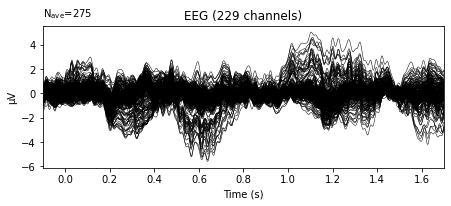

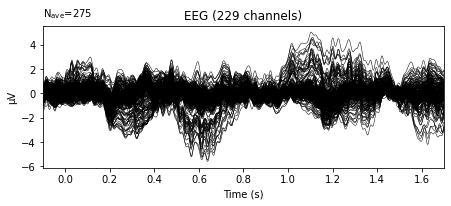

In [16]:
#interpolate your files and plot average to check
epochs_int = epochs.interpolate_bads(reset_bads=False)
epochs_int.average().plot()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


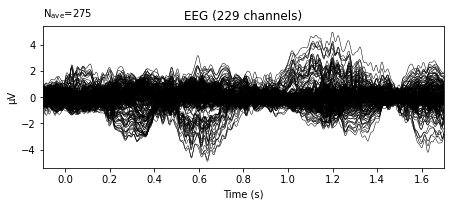

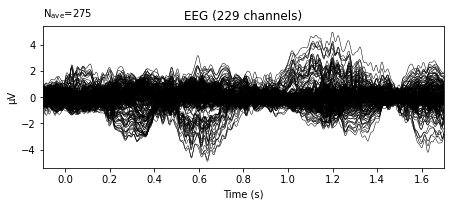

In [17]:
# apply average reference and plot to check
epochs_av = epochs_int.set_eeg_reference('average', projection=False)
epochs_av.average().plot()
#check saved projection = TRUE saves av_ref (Mean across chan= super small for av ref)

## 7. BASELINE CORRECTION

Applying baseline correction (mode: mean)


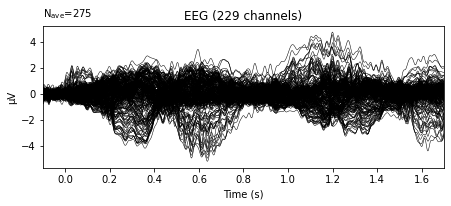

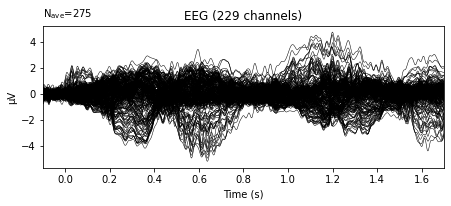

In [18]:
# Baseline correction
interval = (-0.1, 0)
epochs_bc = epochs_av.apply_baseline(interval)
#comment out line 9 to see if it's already applied and whether it changes av ref results
# Plot of baseline-corrected evoked signal
epochs_bc.average().plot()

In [43]:
# Save pre-processed epochs file
print( base_path +sub_s + "_preproc-epo.fif")
epochs_bc.save(base_path + sub_s + "_preproc-epo.fif")

/Users/tivadarr/WorkFiles/Bern/Experiment_1/EEG_data/subjects/P13/P13_preproc-epo.fif


<ipython-input-43-eb56a62732ef>:4: RuntimeWarning: This filename (/Users/tivadarr/WorkFiles/Bern/Experiment_1/EEG_data/subjects/P13/P13_preproc-epo2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_bc.save(base_path + sub_s + "_preproc-epo2.fif")# overwrite=True)


# 4. COMPUTE CONDITION AVERAGES

In [19]:
# Compute and averages for single conditions 
ev_zero = epochs_bc['zero'].average()
ev_hundred = epochs_bc['hundred'].average()
ev_thirty = epochs_bc['silence30'].average()
ev_thirtyone = epochs_bc['target30'].average()
ev_seventy = epochs_bc['silence70'].average()
ev_seventyone = epochs_bc['target70'].average()

# 5. PLOTS

In [20]:
# plot all averages side by side 
#(read in following order row1: left, right; row2: left, right; row3:left, right)
%matplotlib tk
f, axs = plt.subplots(3, 2, figsize=(10, 5))
_ = f.suptitle('averages', fontsize=20)
_ = ev_zero.plot(axes=axs[0, 0], show=False)
_ = ev_hundred.plot(axes=axs[0, 1], show=False)
_ = ev_thirty.plot(axes=axs[1, 0], show=False)
_ = ev_thirtyone.plot(axes=axs[1, 1], show=False)
_ = ev_seventy.plot(axes=axs[2, 0], show=False)
_ = ev_seventyone.plot(axes=axs[2, 1], show=False)
plt.tight_layout()
plt.show()

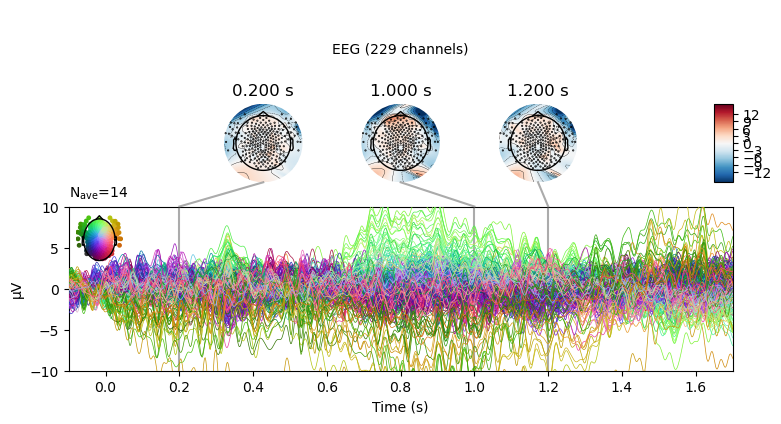

In [21]:
# Topographic maps of contrast of two conditions
seventy,seventyone=ev_seventy, ev_seventyone
%matplotlib tk
# create and plot difference ERP
joint_kwargs = dict(ts_args=dict(time_unit='s',ylim = dict(eeg=[-10, 10])),
                    topomap_args=dict(time_unit='s'))
mne.combine_evoked([seventy,seventyone], weights=[1,-1]).plot_joint(times=[0.2,1.0,1.2],**joint_kwargs)


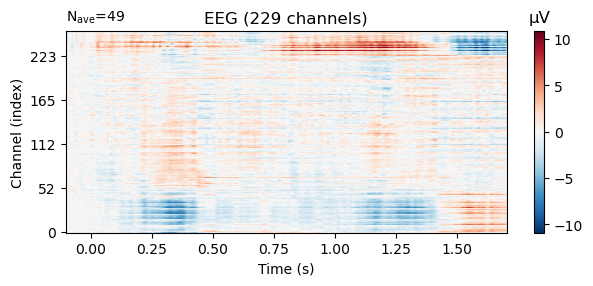

In [22]:
# Heat map of 1 condition
%matplotlib tk
data=ev_seventyone._data
channels=ev_seventyone.ch_names
#print(shape(data))
times=ev_seventyone.times

plt.plot(times, ev_seventyone._data[:,:].T, linewidth = 0.2)
plt.plot(times, ev_seventy._data[:,:].T, linewidth = 0.2)

ev_seventyone.plot_image()

[-100.  -98.  -96.  -94.  -92.  -90.  -88.  -86.  -84.  -82.  -80.  -78.
  -76.  -74.  -72.  -70.  -68.  -66.  -64.  -62.  -60.  -58.  -56.  -54.
  -52.  -50.  -48.  -46.  -44.  -42.  -40.  -38.  -36.  -34.  -32.  -30.
  -28.  -26.  -24.  -22.  -20.  -18.  -16.  -14.  -12.  -10.   -8.   -6.
   -4.   -2.    0.    2.    4.    6.    8.   10.   12.   14.   16.   18.
   20.   22.   24.   26.   28.   30.   32.   34.   36.   38.   40.   42.
   44.   46.   48.   50.   52.   54.   56.   58.   60.   62.   64.   66.
   68.   70.   72.   74.   76.   78.   80.   82.   84.   86.   88.   90.
   92.   94.   96.   98.  100.  102.  104.  106.  108.  110.  112.  114.
  116.  118.  120.  122.  124.  126.  128.  130.  132.  134.  136.  138.
  140.  142.  144.  146.  148.  150.  152.  154.  156.  158.  160.  162.
  164.  166.  168.  170.  172.  174.  176.  178.  180.  182.  184.  186.
  188.  190.  192.  194.  196.  198.  200.  202.  204.  206.  208.  210.
  212.  214.  216.  218.  220.  222.  224.  226.  2

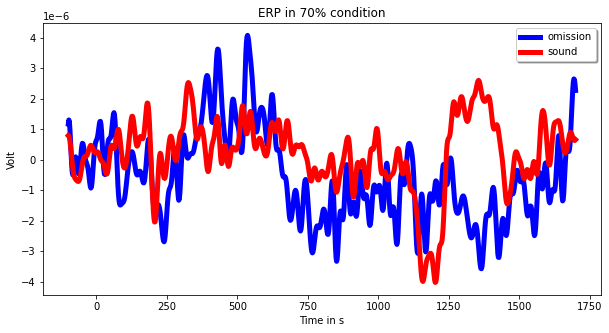

In [55]:
# Single Channel ERP plots 
from matplotlib import pyplot as plt
%matplotlib inline

times=times*1000
print(times)
ch = 180
conditions = ['omission', 'sound']

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel('Time in s')
ax.set_ylabel('Volt')

ax.plot(times,ev_seventy._data[ch, :], color='blue', label='omission', linewidth = 5)
ax.plot(times,ev_seventyone._data[ch, :], color='red', label='sound',  linewidth = 5)

legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')
plt.title('ERP in 70% condition')
plt.show()